<a href="https://colab.research.google.com/github/nekotanku/colab/blob/master/pytorch_CNN_%E3%83%87%E3%83%BC%E3%82%BF%E6%8B%A1%E5%BC%B5%E7%89%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import  DataLoader

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

In [ ]:
#前処理
val_transform = transforms.Compose([
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, ), (0.5,))
])

train_transform = transforms.Compose([
                                #ランダムに左右を入れ替える
                                transforms.RandomHorizontalFlip(), 
                                #ランダムに色調をかえる
                                transforms.ColorJitter(),
                                #ランダムに回転-10~+10
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5,)),
])

#訓練用データセット
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [ ]:
#Dataloader
train_dataloader  = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
data_iter = iter(train_dataloader)

In [ ]:
imgs, labels =  data_iter.next()

In [ ]:
labels

tensor([6, 4, 8, 0, 7, 5, 4, 6, 6, 9, 6, 7, 0, 8, 7, 5, 6, 1, 4, 8, 6, 9, 3, 2,
        5, 1, 1, 7, 8, 6, 1, 0])

In [ ]:
#(ミニバッチ, channel, H, W)
imgs.size()

torch.Size([32, 3, 32, 32])

In [ ]:
img = imgs[0]


In [ ]:
#channel Lastに変換
img_permute = img.permute(1,2,0)

In [ ]:
img_permute  = 0.5 * img_permute + 0.5

In [ ]:
img_permute = np.clip(img_permute, 0, 1)

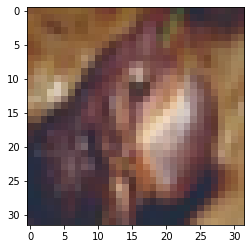

In [ ]:
plt.imshow(img_permute)

In [ ]:
labels

tensor([6, 4, 8, 0, 7, 5, 4, 6, 6, 9, 6, 7, 0, 8, 7, 5, 6, 1, 4, 8, 6, 9, 3, 2,
        5, 1, 1, 7, 8, 6, 1, 0])

In [ ]:
#CNN定義
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.featuers = nn.Sequential(#初期　32*32
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),#16*16
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), #8*8
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),#4*4
            #絞る
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes
    )
    
    def forward(self, x):
        x = self.featuers(x)
        #1次元配列に直すx.size(0)=バッチ数、それ以外は適当に振り分け
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
model = CNN(10)
model.to(device)

CNN(
  (featuers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [ ]:
num_epochs =15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    #train_loop
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)
    
    
    #validation_loop
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print("epoch:{}, loss: {}, acc:{}, val_loss:{}, val_acc:{}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc) )


epoch:0, loss: 1.4242028304574128, acc:0.484404981136322, val_loss:1.1173527031279982, val_acc:0.6080271601676941
epoch:1, loss: 1.0116981974566357, acc:0.643634021282196, val_loss:0.8793099923446156, val_acc:0.6882987022399902
epoch:2, loss: 0.8549791859344877, acc:0.7005558013916016, val_loss:0.7933590339776426, val_acc:0.721345841884613
epoch:3, loss: 0.7742257079327632, acc:0.7281869649887085, val_loss:0.771261501521729, val_acc:0.7340255379676819
epoch:4, loss: 0.717929034252542, acc:0.7486404180526733, val_loss:0.747121844714442, val_acc:0.7382188439369202
epoch:5, loss: 0.6793211461810522, acc:0.7631957530975342, val_loss:0.6927485002782017, val_acc:0.7631788849830627
epoch:6, loss: 0.6459976573232192, acc:0.7763915657997131, val_loss:0.659964212356284, val_acc:0.7713658213615417
epoch:7, loss: 0.6262536296574488, acc:0.782469630241394, val_loss:0.6644014641404533, val_acc:0.7693690061569214
epoch:8, loss: 0.6075228209382666, acc:0.7887476086616516, val_loss:0.6813807601745898, 

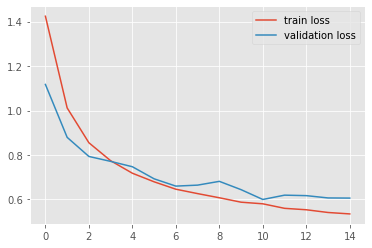

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

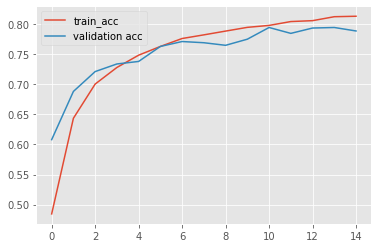

In [ ]:
plt.plot(accs, label="train_acc")
plt.plot(val_accs, label="validation acc")
plt.legend()